In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np
from IPython.display import display, HTML

%matplotlib inline

# ==========================================
# KONFIGURATION
# ==========================================
RUNS_DIR = Path(r"C:\Users\ahnaf.karim\Downloads\ML_UE3-main\ML_UE3-main\runs")

# Wähle den Datensatz (wichtig für den Vergleich)
SELECTED_DATASET = "cifar10
" 

# Sortiermetrik
SORT_METRIC = "overall_accuracy"

# Ansicht begrenzen (z.B. auf 20 Epochen zoomen, oder None für alle)
MAX_VIEW_EPOCH = None  

print(f"Analyse für Dataset: {SELECTED_DATASET}")

Analyse für Dataset: cifar10


In [71]:
def load_and_prep_data(root_dir, dataset_filter=None):
    all_data = []
    if not root_dir.exists():
        print(f"❌ Fehler: {root_dir} nicht gefunden.")
        return pd.DataFrame()
    
    configs = list(root_dir.rglob("config.json"))
    print(f"Scanne {len(configs)} Konfigurationen...")

    for config_path in configs:
        run_folder = config_path.parent
        metrics_path = run_folder / "metrics.json"
        history_path = run_folder / "history.json"
        
        if metrics_path.exists() and history_path.exists():
            try:
                cfg = json.loads(config_path.read_text())
                met = json.loads(metrics_path.read_text())
                hist = json.loads(history_path.read_text())
                
                # Filter Dataset
                if dataset_filter and cfg.get("dataset", "").lower() != dataset_filter.lower():
                    continue

                entry = {**cfg, **met}
                entry["run_id"] = run_folder.name
                entry["history"] = hist
                
                # Parameter für saubere Plots formatieren
                entry["Augmentation"] = "Ja" if entry.get("augment", 0) else "Nein"
                entry["Dropout"] = str(entry.get("dropout", 0.0))
                entry["Learning Rate"] = str(entry.get("lr", 0.0))
                
                all_data.append(entry)
            except Exception as e:
                pass # Fehlerhafte Runs ignorieren

    return pd.DataFrame(all_data)

df = load_and_prep_data(RUNS_DIR, SELECTED_DATASET)
print(f"--> {len(df)} Runs für '{SELECTED_DATASET}' geladen.")

Scanne 109 Konfigurationen...
--> 60 Runs für 'cifar10' geladen.


--- BENCHMARK KURVEN ---
Grün = Mit Augmentation | Rot = Ohne Augmentation
Linienart = Verschiedene Dropout Werte


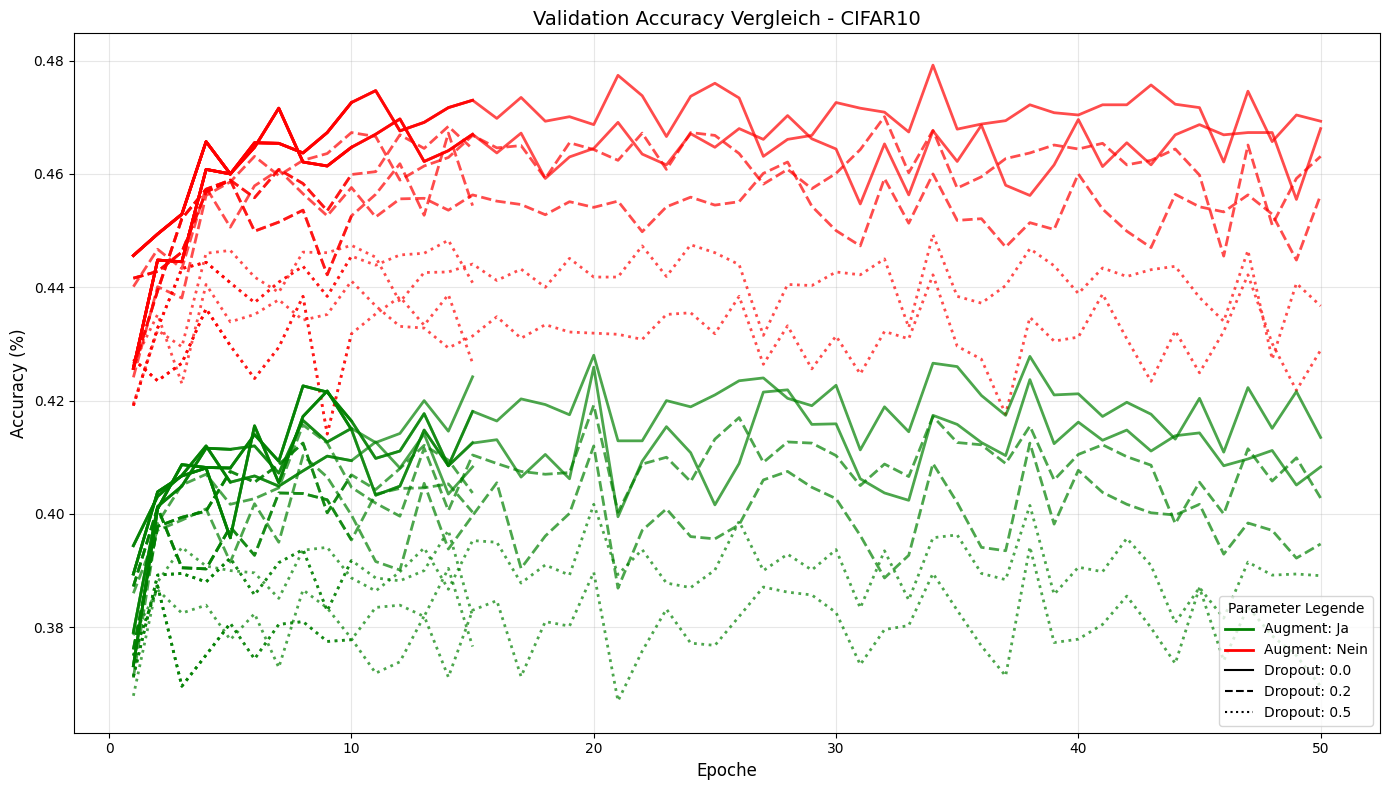

In [72]:
def plot_benchmark_curves(df):
    if df.empty: return

    plt.figure(figsize=(14, 8))
    
    # Farbpalette definieren (Rot für Nein, Grün für Ja)
    colors = {"Ja": "green", "Nein": "red"}
    linestyles = ["-", "--", ":", "-."] # Für verschiedene Dropouts
    
    # Liste der verfügbaren Dropouts sortieren für konsistente Linienarten
    unique_dropouts = sorted(df["Dropout"].unique())
    
    for _, row in df.iterrows():
        hist = row["history"]
        
        # Validation Accuracy Key finden
        val_acc_key = next((k for k in ['eval_acc', 'val_acc', 'balanced_accuracy'] if k in hist), None)
        
        if val_acc_key and len(hist[val_acc_key]) > 0:
            # Daten begrenzen falls gewünscht
            data = hist[val_acc_key]
            if MAX_VIEW_EPOCH:
                data = data[:MAX_VIEW_EPOCH]
            
            epochs = range(1, len(data) + 1)
            
            # Styling basierend auf deinen Parametern
            aug = row["Augmentation"]
            drop = row["Dropout"]
            lr = row["Learning Rate"]
            
            # Linienstil basierend auf Dropout wählen
            ls_idx = unique_dropouts.index(drop) % len(linestyles)
            ls = linestyles[ls_idx]
            
            # Plotten
            plt.plot(epochs, data, 
                     color=colors.get(aug, "blue"), 
                     linestyle=ls, 
                     alpha=0.7, 
                     linewidth=2,
                     label=f"Aug={aug}, Drop={drop}, LR={lr}")

    plt.title(f"Validation Accuracy Vergleich - {SELECTED_DATASET.upper()}", fontsize=14)
    plt.xlabel("Epoche", fontsize=12)
    plt.ylabel("Accuracy (%)", fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Custom Legende bauen, damit sie nicht explodiert
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color="green", lw=2, label='Augment: Ja'),
                    Line2D([0], [0], color="red", lw=2, label='Augment: Nein')]
    
    # Füge Styles für Dropout hinzu
    for i, drop in enumerate(unique_dropouts):
        custom_lines.append(Line2D([0], [0], color="black", linestyle=linestyles[i%4], label=f'Dropout: {drop}'))

    plt.legend(handles=custom_lines, loc='lower right', title="Parameter Legende")
    
    plt.tight_layout()
    plt.show()

print("--- BENCHMARK KURVEN ---")
print("Grün = Mit Augmentation | Rot = Ohne Augmentation")
print("Linienart = Verschiedene Dropout Werte")
plot_benchmark_curves(df)


==================== HYPERPARAMETER ANALYSE ====================



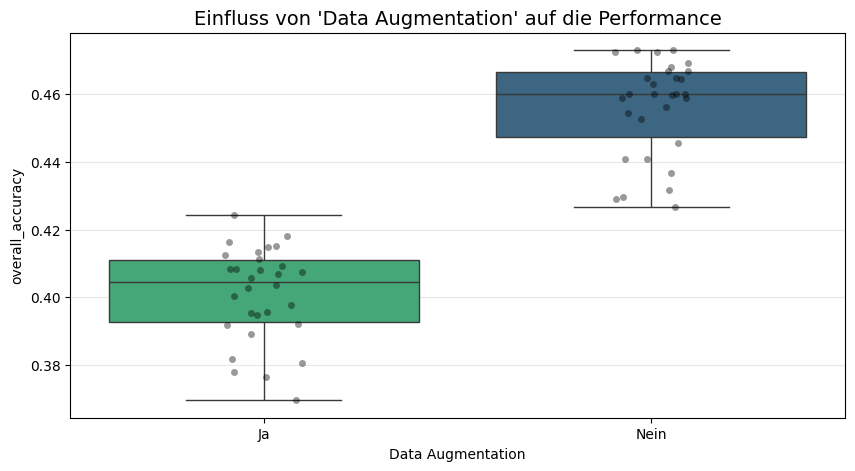

Statistik für Data Augmentation:


------------------------------------------------------------


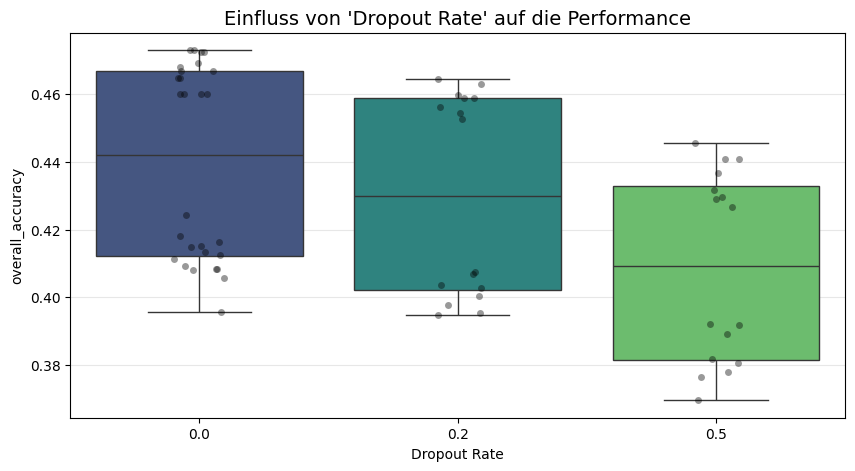

Statistik für Dropout Rate:


------------------------------------------------------------


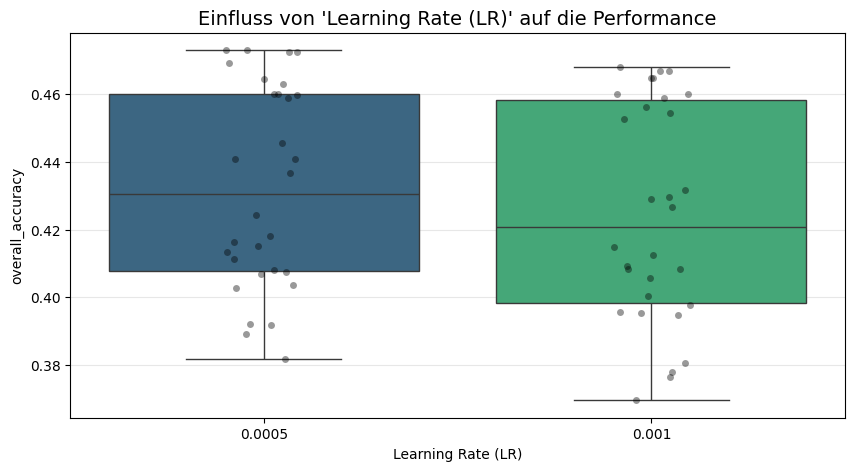

Statistik für Learning Rate (LR):


------------------------------------------------------------


--- TOP 5 MODELLE ---


,model,Augmentation,Dropout,Learning Rate,epochs,balanced_accuracy
5,resnet18,Nein,0.0,0.0005,15,0.4730
4,resnet18,Nein,0.0,0.0005,15,0.4730
0,resnet18,Nein,0.0,0.0005,10,0.4726
1,resnet18,Nein,0.0,0.0005,10,0.4726
8,resnet18,Nein,0.0,0.0005,50,0.4693


In [73]:
def analyze_parameter_impact(df, param_col, title):
    if df.empty: return
    
    # 1. VISUALISIERUNG (Boxplot)
    plt.figure(figsize=(10, 5))
    
    # Sortierung für den Plot
    order = sorted(df[param_col].unique())
    
    sns.boxplot(data=df, x=param_col, y=SORT_METRIC, order=order, palette="viridis", hue=param_col)
    sns.stripplot(data=df, x=param_col, y=SORT_METRIC, color="black", alpha=0.4, jitter=True) # Zeigt einzelne Punkte
    
    plt.title(f"Einfluss von '{title}' auf die Performance", fontsize=14)
    plt.ylabel(SORT_METRIC)
    plt.xlabel(title)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    # 2. TABELLE (Durchschnittswerte)
    print(f"Statistik für {title}:")
    summary = df.groupby(param_col)[["overall_accuracy", "balanced_accuracy"]].agg(['mean', 'max', 'count'])
    # Tabelle schön formatieren
    display(summary.style.background_gradient(cmap="Greens", subset=[('balanced_accuracy', 'mean')]).format("{:.4f}"))
    print("-" * 60)

if not df.empty:
    print(f"\n{'='*20} HYPERPARAMETER ANALYSE {'='*20}\n")
    
    # 1. AUGMENTATION (Dein wichtigster)
    analyze_parameter_impact(df, "Augmentation", "Data Augmentation")
    
    # 2. DROPOUT
    analyze_parameter_impact(df, "Dropout", "Dropout Rate")
    
    # 3. LEARNING RATE
    analyze_parameter_impact(df, "Learning Rate", "Learning Rate (LR)")
    
    # 4. BESTENLISTE
    print("\n\n--- TOP 5 MODELLE ---")
    cols = ["model", "Augmentation", "Dropout", "Learning Rate", "epochs", "balanced_accuracy"]
    display(df.sort_values(by="balanced_accuracy", ascending=False)[cols].head(5))

Erstelle Plot für LR=0.001 ...


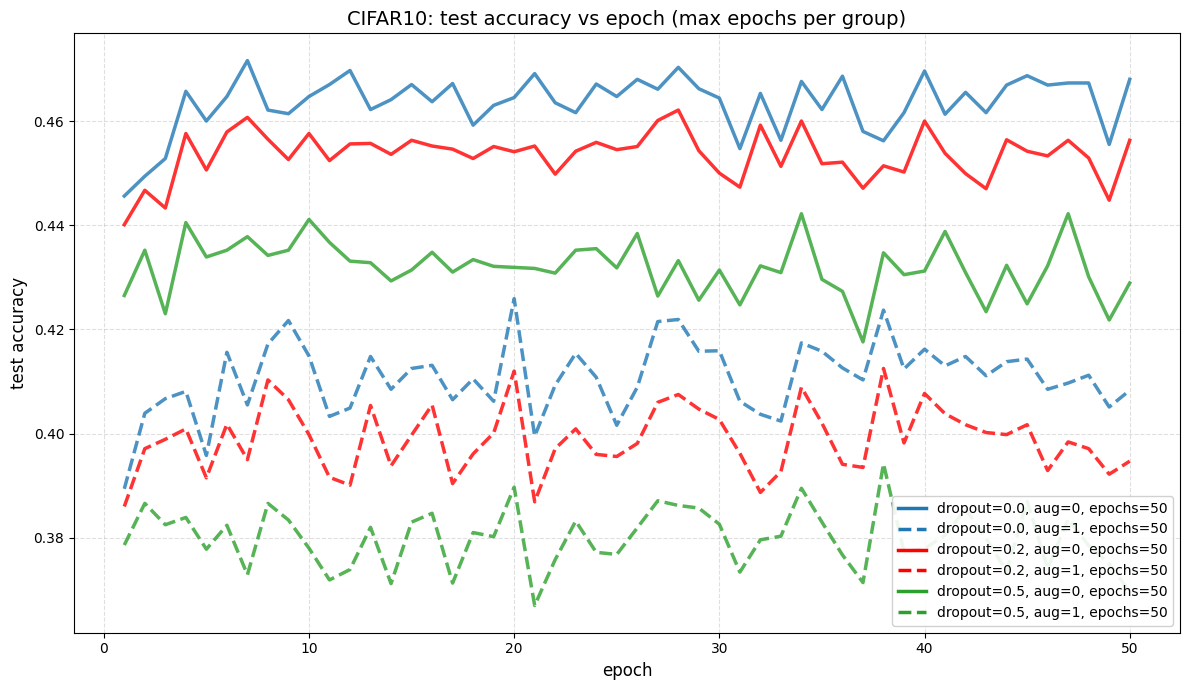

In [74]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import seaborn as sns

# ==========================================
# SETUP & KONFIGURATION
# ==========================================
TARGET_LR = 0.001  # Fixierte Learning Rate

# 1. LINIENSTIL für AUGMENTATION (Dein Wunsch)
# 0 (Aus) = Durchgezogen, 1 (An) = Gestrichelt
LINESTYLES = {
    0: "-",      # Solid
    1: "--"      # Dashed
}

# 2. FARBEN für DROPOUT
COLORS = {
    0.0: "#1f77b4",  # Blau
    0.2: "#ff0000",  # Rot
    0.5: "#2ca02c",  # Grün
}

def plot_dropout_color_analysis(df, fixed_lr):
    if df.empty: 
        return
    
    # Filter: Nur Runs mit der fixen LR
    subset = df[df["lr"].apply(lambda x: np.isclose(x, fixed_lr))].copy()
    
    if subset.empty:
        print(f"⚠️ Keine Runs mit LR={fixed_lr} gefunden.")
        return
    
    print(f"Erstelle Plot für LR={fixed_lr} ...")
    
    # Epochs-Spalte hinzufügen falls nicht vorhanden
    if 'epochs' not in subset.columns:
        subset['epochs'] = subset['history'].apply(lambda h: len(h.get('eval_acc', h.get('val_acc', h.get('overall_accuracy', [])))))
    
    # Für jede Kombination von dropout und augment nur die Version mit max epochs behalten
    subset = subset.loc[subset.groupby(['dropout', 'augment'])['epochs'].idxmax()]
    
    plt.figure(figsize=(12, 7))
    
    # Sortieren für konsistente Legende
    subset = subset.sort_values(by=["dropout", "augment"])
    
    # Legendeneinträge sammeln
    legend_elements = []
    
    for _, row in subset.iterrows():
        hist = row["history"]
        val_acc_key = next((k for k in ['eval_acc', 'val_acc', 'overall_accuracy'] if k in hist), None)
        
        if val_acc_key and len(hist[val_acc_key]) > 0:
            y_data = hist[val_acc_key]
            x_data = range(1, len(y_data) + 1)
            
            # Parameter
            aug = int(row.get("augment", 0))
            drop = float(row.get("dropout", 0.0))
            epochs = int(row.get("epochs", len(y_data)))
            
            # Encoding anwenden
            ls = LINESTYLES.get(aug, "-")
            c = COLORS.get(drop, "gray")
            
            plt.plot(x_data, y_data, color=c, linestyle=ls, linewidth=2.5, alpha=0.8)
            
            # Legendeneintrag erstellen
            label = f"dropout={drop}, aug={aug}, epochs={epochs}"
            legend_elements.append(
                Line2D([0], [0], 
                       color=c, 
                       linestyle=ls,
                       lw=2.5, 
                       label=label)
            )
    
    # Design
    plt.title(f"CIFAR10: test accuracy vs epoch (max epochs per group)", fontsize=14)
    plt.xlabel("epoch", fontsize=12)
    plt.ylabel("test accuracy", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.4)
    
    plt.legend(handles=legend_elements, loc='lower right', framealpha=0.9, fontsize=10)
    plt.tight_layout()
    plt.show()

# Ausführen
plot_dropout_color_analysis(df, TARGET_LR)

In [75]:
import pandas as pd
import numpy as np
from IPython.display import display

# ==========================================
# KONFIGURATION
# ==========================================
TARGET_LR = 0.001
METRIC_COL = "overall_accuracy"  # "Normale" Accuracy

def get_saturation_epoch(history):
    """Findet die Epoche mit dem höchsten Val-Accuracy Wert."""
    # Mögliche Keys durchsuchen
    keys = ['eval_acc', 'val_acc', 'val_accuracy', 'balanced_accuracy', 'accuracy']
    val_acc_key = next((k for k in keys if k in history), None)
    
    if val_acc_key and history[val_acc_key]:
        values = history[val_acc_key]
        # argmax gibt den Index des höchsten Wertes zurück
        # +1, da Epochen bei 1 anfangen, Indizes aber bei 0
        return np.argmax(values) + 1, max(values)
    return None, 0

def create_summary_table(df, fixed_lr):
    if df.empty: return

    # 1. Filtern nach LR
    subset = df[df["lr"].apply(lambda x: np.isclose(x, fixed_lr))].copy()
    
    if subset.empty:
        print(f"⚠️ Keine Runs mit LR={fixed_lr} gefunden.")
        return

    # 2. Sättigungs-Epoche berechnen
    # Wir speichern das direkt im DataFrame
    saturation_data = subset["history"].apply(get_saturation_epoch)
    subset["best_epoch"] = saturation_data.apply(lambda x: x[0])
    # Sicherheitshalber: Falls metrics.json fehlt, nehmen wir den Max-Wert aus der History
    # subset["max_hist_acc"] = saturation_data.apply(lambda x: x[1]) 

    # 3. Den "längsten" Run pro Kombination finden
    # Wir sortieren erst nach Epochen (absteigend), damit die längsten oben stehen
    subset = subset.sort_values(by="epochs", ascending=False)
    
    # Jetzt gruppieren wir nach Augment & Dropout und nehmen den ersten Eintrag (der längste)
    # as_index=False sorgt dafür, dass Augment/Dropout normale Spalten bleiben
    best_runs = subset.drop_duplicates(subset=["augment", "dropout"])

    # 4. Tabelle aufräumen und formatieren
    # Wir wählen nur die Spalten, die dich interessieren
    cols_to_show = [
        "augment", 
        "dropout", 
        "epochs",             # Wie lange lief es insgesamt?
        "best_epoch",         # Wann war es am besten?
        METRIC_COL            # Wie gut war es am Ende/im Test?
    ]
    
    # Falls Spalten fehlen (z.B. Typos), nur vorhandene nehmen
    cols_to_show = [c for c in cols_to_show if c in best_runs.columns]
    
    final_table = best_runs[cols_to_show].sort_values(by=["augment", "dropout"])
    
    # Spalten umbenennen für schönere Ausgabe
    rename_map = {
        "augment": "Augmentation",
        "dropout": "Dropout",
        "epochs": "Total Epochs",
        "best_epoch": "Best Epoch (Saturation)",
        METRIC_COL: "Accuracy (Overall)"
    }
    final_table = final_table.rename(columns=rename_map)

    # 5. Anzeigen mit Styling
    print(f"--- DETAIL ANALYSE (LR={fixed_lr}) ---")
    print("Best Epoch: Ab dieser Epoche verbesserte sich die Accuracy nicht mehr.")
    
    display(final_table.style.background_gradient(
        subset=["Accuracy (Overall)"], cmap="Greens"
    ).background_gradient(
        subset=["Best Epoch (Saturation)"], cmap="Blues"
    ).format({
        "Accuracy (Overall)": "{:.4%}", # Als Prozent formatieren
        "Best Epoch (Saturation)": "{:.0f}",
        "Dropout": "{:.1f}"
    }))

# Ausführen
create_summary_table(df, TARGET_LR)

--- DETAIL ANALYSE (LR=0.001) ---
Best Epoch: Ab dieser Epoche verbesserte sich die Accuracy nicht mehr.


,Augmentation,Dropout,Total Epochs,Best Epoch (Saturation),Accuracy (Overall)
9,0,0.0,50,7,46.8000%
19,0,0.2,50,28,45.6300%
27,0,0.5,50,34,42.8900%
39,1,0.0,50,20,40.8300%
49,1,0.2,50,38,39.4700%
57,1,0.5,50,38,36.9600%


In [76]:
import pandas as pd
import numpy as np
from IPython.display import display
from pathlib import Path

# ==========================================
# KONFIGURATION
# ==========================================
TARGET_LR = 0.001
METRIC_COL = "overall_accuracy"
# Toleranz-Schwelle: Ab wann lohnt es sich nicht mehr?
# 0.01 bedeutet: Wenn wir 99% des Max-Wertes erreicht haben, gilt es als "fertig".
THRESHOLD_TOLERANCE = 0.02

def get_convergence_info(history):
    """
    Berechnet zwei Dinge:
    1. Wann war das absolute Maximum? (Saturation)
    2. Wann waren wir schon 'gut genug' (99% des Max)? (Efficiency)
    """
    # Keys finden
    keys = ['eval_acc', 'val_acc', 'val_accuracy', 'balanced_accuracy', 'overall_accuracy', 'accuracy']
    val_acc_key = next((k for k in keys if k in history), None)
    
    if val_acc_key and history[val_acc_key]:
        values = history[val_acc_key]
        
        # 1. Absolutes Maximum finden
        max_idx = np.argmax(values)
        max_val = values[max_idx]
        
        # 2. "Efficient Epoch" finden (Erstes Mal über 99% des Max)
        # Wir suchen den ersten Index, wo der Wert >= (1 - Toleranz) * Max ist
        target_val = max_val * (1 - THRESHOLD_TOLERANCE)
        
        # np.where gibt alle Indizes zurück, die die Bedingung erfüllen. Wir nehmen den ersten (min).
        # Wir suchen nur BIS zum absoluten Max (alles danach ist eh Schwankung)
        candidates = np.where(np.array(values[:max_idx+1]) >= target_val)[0]
        
        if len(candidates) > 0:
            eff_idx = candidates[0]
            eff_acc = values[eff_idx]  # Accuracy beim efficient epoch
        else:
            eff_idx = max_idx  # Fallback
            eff_acc = max_val
            
        return {
            "max_epoch": max_idx + 1,
            "max_acc": max_val,
            "eff_epoch": eff_idx + 1,
            "eff_acc": eff_acc
        }
        
    return {"max_epoch": None, "max_acc": 0, "eff_epoch": None, "eff_acc": 0}

def create_advanced_summary(df, fixed_lr, dataset_name="gtsrb", output_dir="analyse_plot"):
    if df.empty: 
        return
    
    # 1. Filtern
    subset = df[df["lr"].apply(lambda x: np.isclose(x, fixed_lr))].copy()
    if subset.empty:
        print(f"⚠️ Keine Runs mit LR={fixed_lr}")
        return
    
    # 2. Metriken berechnen
    # Wir wenden die Funktion auf jede History an und machen daraus direkt Spalten
    metrics_df = subset["history"].apply(lambda h: pd.Series(get_convergence_info(h)))
    
    # Verbinden mit den Originaldaten
    subset = pd.concat([subset, metrics_df], axis=1)
    
    # 3. Den "längsten" Run pro Kombination finden
    subset = subset.sort_values(by="epochs", ascending=False)
    best_runs = subset.drop_duplicates(subset=["augment", "dropout"])
    
    # 4. Tabelle bauen
    cols = [
        "augment", 
        "dropout", 
        "epochs",       # Gesamtlänge
        "max_acc",      # Beste Accuracy
        "max_epoch",    # Wann war das Absolute Max?
        "eff_epoch",    # Wann waren wir bei 99%?
        "eff_acc"       # Accuracy beim Efficient Epoch
    ]
    
    final_table = best_runs[cols].sort_values(by=["augment", "dropout"])
    
    # Umbenennen
    final_table = final_table.rename(columns={
        "augment": "Augment",
        "dropout": "Drop",
        "epochs": "Total Eps",
        "max_acc": "Max Acc",
        "max_epoch": "Peak Ep", 
        "eff_epoch": f"Efficient Ep ({int((1-THRESHOLD_TOLERANCE)*100)}%)",
        "eff_acc": f"Acc @ Efficient Ep"
    })
    
    # 5. CSV speichern
    output_path = Path(output_dir)
    output_path.mkdir(exist_ok=True)
    
    csv_filename = f"{dataset_name}_convergence_analysis_lr{fixed_lr}.csv"
    csv_filepath = output_path / csv_filename
    final_table.to_csv(csv_filepath, index=False)
    print(f"✓ Tabelle gespeichert: {csv_filepath}")
    
    # 6. Anzeige
    print(f"\n--- KONVERGENZ ANALYSE (LR={fixed_lr}) ---")
    print(f"Peak Ep: Die Epoche mit dem allerhöchsten Wert.")
    print(f"Efficient Ep: Die erste Epoche, die {1-THRESHOLD_TOLERANCE:.1%} dieses Peaks erreichte.")
    print("Interpretation: Wenn 'Efficient Ep' viel kleiner ist als 'Total Eps', hättest du früher aufhören können.\n")
    
    display(final_table.style.background_gradient(
        subset=["Max Acc"], cmap="Greens"
    ).background_gradient(
        subset=[f"Efficient Ep ({int((1-THRESHOLD_TOLERANCE)*100)}%)"], cmap="YlOrRd_r"  # Rot = Spät (Schlecht), Gelb = Früh (Gut)
    ).format({
        "Max Acc": "{:.2%}",
        "Peak Ep": "{:.0f}",
        f"Efficient Ep ({int((1-THRESHOLD_TOLERANCE)*100)}%)": "{:.0f}",
        f"Acc @ Efficient Ep": "{:.2%}",
        "Drop": "{:.1f}"
    }))
    
    return final_table

# Ausführen
result_table = create_advanced_summary(df, TARGET_LR, dataset_name=SELECTED_DATASET)

✓ Tabelle gespeichert: analyse_plot\cifar10_convergence_analysis_lr0.001.csv

--- KONVERGENZ ANALYSE (LR=0.001) ---
Peak Ep: Die Epoche mit dem allerhöchsten Wert.
Efficient Ep: Die erste Epoche, die 98.0% dieses Peaks erreichte.
Interpretation: Wenn 'Efficient Ep' viel kleiner ist als 'Total Eps', hättest du früher aufhören können.



,Augment,Drop,Total Eps,Max Acc,Peak Ep,Efficient Ep (98%),Acc @ Efficient Ep
9,0,0.0,50,47.16%,7,4,46.57%
19,0,0.2,50,46.21%,28,4,45.76%
27,0,0.5,50,44.22%,34,2,43.52%
39,1,0.0,50,42.59%,20,9,42.17%
49,1,0.2,50,41.25%,38,8,41.03%
57,1,0.5,50,39.42%,38,2,38.66%
